# Introduction to the Project.
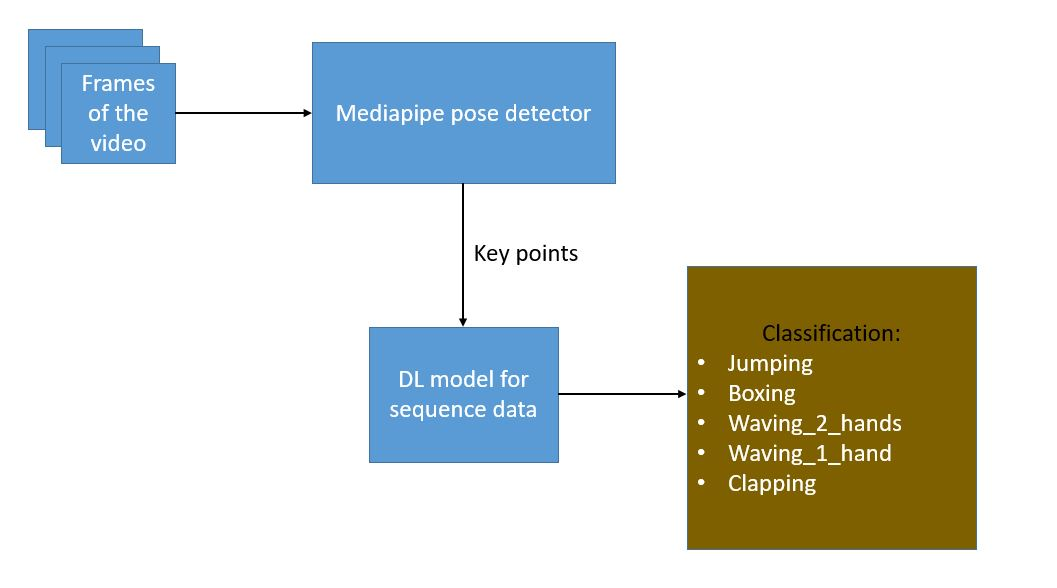

## Dataset Preparation

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset has following classes.

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

We can download the dataset from this : https://drive.google.com/open?id=1IuZlyNjg6DMQE3iaO1Px6h1yLKgatynt

To get the understand about the dataset use this link
https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input

In [1]:
import gdown
import shutil
import os

if os.path.exists('./sample_data'):
  shutil.rmtree("sample_data")
if os.path.exists('./RNN-HAR-2D-Pose-database'):
  shutil.rmtree("RNN-HAR-2D-Pose-database")
  
url = "https://drive.google.com/uc?export=download&id=1IuZlyNjg6DMQE3iaO1Px6h1yLKgatynt"
output = 'dataset.zip'
gdown.download(url, output, quiet=False)
shutil.unpack_archive('dataset.zip', "./")
os.remove("dataset.zip")

Downloading...
From: https://drive.google.com/uc?export=download&id=1IuZlyNjg6DMQE3iaO1Px6h1yLKgatynt
To: /content/dataset.zip
100%|██████████| 20.1M/20.1M [00:00<00:00, 171MB/s]


##### Now we downloaded the dataset. Now we are going to do some preprocessing to the dataset. We are not going to use Openpose as the pose detector. We are going to use mediapipe poss detector. So we have to filter some features from the dataset so that those features will be in the mediapipe pose estimater. 

These are the joint coordinates that we have in the datset. "j" means joint.

("j0_x", "j0_y", "j1_x", "j1_y" , "j2_x", "j2_y", "j3_x", "j3_y", "j4_x", "j4_y", "j5_x", "j5_y", "j6_x", "j6_y", "j7_x"," j7_y", "j8_x", "j8_y", "j9_x", "j9_y", "j10_x", "j10_y", "j11_x", "j11_y", "j12_x", "j12_y", "j13_x", "j13_y", "j14_x", "j14_y", "j15_x", "j15_y", "j16_x", "j16_y", "j17_x", "j17_y")

But when we are doing inferencing we have to use mediapipe. So we will be using only following joints for the model training.

(j0, j2, j3, j4, j5, j6, j7, j8, j9, j10, j11, j12, j13, j16, j17)
  

In [2]:
import pandas as pd
import numpy as np
train_x = pd.read_csv("./RNN-HAR-2D-Pose-database/X_train.txt",header=None).to_numpy()
train_y = pd.read_csv("./RNN-HAR-2D-Pose-database/Y_train.txt",header=None).to_numpy()-1

test_x = pd.read_csv("./RNN-HAR-2D-Pose-database/X_test.txt",header=None).to_numpy()
test_y = pd.read_csv("./RNN-HAR-2D-Pose-database/Y_test.txt",header=None).to_numpy()-1

n_steps = 32 # 32 timesteps per series
num_blocks_train = int(train_x.shape[0]/n_steps)
num_blocks_test = int(test_x.shape[0]/n_steps)
train_x = np.array(np.split(train_x,num_blocks_train))# We have to split the dataset into time frames of 32. See dataset documentation.
test_x = np.array(np.split(test_x,num_blocks_test))

filt = [0,1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,32,33,34,35] # Filtering needed joint coordinates
train_x = train_x[:,:,filt]
test_x = test_x[:,:,filt]
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(22625, 32, 30) (22625, 1)
(5751, 32, 30) (5751, 1)


In [3]:
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"
] 
n_classes = len(LABELS)

### Deeplearning Model

In [4]:
from tensorflow import keras
import tensorflow as tf

def make_model(input_shape,n_classes):

    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=train_x.shape[1:],n_classes=n_classes)
#keras.utils.plot_model(model, show_shapes=True)

In [5]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [6]:
# This callback will save the best model during training.
save = tf.keras.callbacks.ModelCheckpoint(
    "/content/saved/we2.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

model.fit(train_x,train_y,epochs=10,validation_data=(test_x,test_y),callbacks=[save],shuffle=True)

Epoch 1/10
708/708 [==============================] - 12s 16ms/step - loss: 0.3070 - accuracy: 0.9028 - val_loss: 0.9135 - val_accuracy: 0.7133
Epoch 2/10
708/708 [==============================] - 14s 20ms/step - loss: 0.0860 - accuracy: 0.9734 - val_loss: 0.2957 - val_accuracy: 0.9164
Epoch 3/10
708/708 [==============================] - 11s 15ms/step - loss: 0.0523 - accuracy: 0.9837 - val_loss: 4.1274 - val_accuracy: 0.4222
Epoch 4/10
708/708 [==============================] - 11s 15ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.3853 - val_accuracy: 0.8729
Epoch 5/10
708/708 [==============================] - 10s 14ms/step - loss: 0.0350 - accuracy: 0.9896 - val_loss: 0.4879 - val_accuracy: 0.8498
Epoch 6/10
708/708 [==============================] - 10s 15ms/step - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.4853 - val_accuracy: 0.8718
Epoch 7/10
708/708 [==============================] - 10s 15ms/step - loss: 0.0260 - accuracy: 0.9925 - val_loss: 1.5636 - val_accuracy:

In [7]:
model.load_weights("/content/saved/we2.h5") # Load the saved best model
model.evaluate(test_x,test_y) # Evaluate the best model

180/180 [==============================] - 1s 5ms/step - loss: 0.1015 - accuracy: 0.9699


[0.1015099585056305, 0.9699182510375977]

In [8]:
print("Prediction: ",np.round(model.predict(np.array([test_x[2000]]))))
print("label: ",test_y[2000])

Prediction:  [[0. 0. 1. 0. 0. 0.]]
label:  [2]


### Key point detector Mediapipe

In [18]:
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [34]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import time

input_video = "./Input_videos/3.mp4"
output_folder = "./output_videos"
output_video = os.path.join(output_folder,str(time.time())+".mp4")

W, H = 852, 480 # Width and height of the video
mp_pose = mp.solutions.pose
pose_model = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

Following function will convert mediapipe keypoint object into numpy array in desired format.

In [35]:
def get_processed_pose(img,results,draw):

  def extract_xys(ob):
    p = np.array([ob.x,ob.y])
    return p

  two_d_pose = {  "j2": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER],
                  "j5": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER],
                  "j8": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP],
                  "j11": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP],
                  "j9": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE],
                  "j12": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE],
                  "j10": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE],
                  "j13": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE],
                  "j0": results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE],
                  "j3": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW],
                  "j6": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW],
                  "j4": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST],
                  "j7": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST],
                  "j16": results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EYE],
                  "j17": results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EYE]
                  }

  pose_d= dict(map(lambda x: (x[0], extract_xys(x[1])), two_d_pose.items()))

  pose = np.array([
    pose_d["j0"],
    pose_d["j2"],
    pose_d["j3"],
    pose_d["j4"],
    pose_d["j5"],
    pose_d["j6"],
    pose_d["j7"],
    pose_d["j8"],
    pose_d["j9"],
    pose_d["j10"],
    pose_d["j11"],
    pose_d["j12"],
    pose_d["j13"],
    pose_d["j16"],
    pose_d["j17"]]
    )
  pose = pose*np.array([W, H]) # Get original coordinates
  f_pose = np.reshape(pose,(30))

  if draw:
    img.flags.writeable = True
    mp_drawing.draw_landmarks(
        img,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
  return f_pose, img

In [36]:
cap = cv2.VideoCapture(input_video)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
cap_rec = cv2.VideoWriter(output_video, fourcc, int(cap.get(cv2.CAP_PROP_FPS)),(W, H)) # Recording object

seq=np.zeros((32,30),dtype=np.float32).tolist() # Initial sample: We will append new key points to this list
while True:
    success, img_or = cap.read()
    if not success:
        break

    try:
      
      img = cv2.resize(img_or.copy(), (W, H), interpolation=cv2.INTER_NEAREST)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      results = pose_model.process(img)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      p,img = get_processed_pose(img, results,draw=True)
      seq.append(p)# append new pose
      seq.pop(0)# remove oldest pose so that our buffer will be same length
      pred = np.round(model.predict(np.array([np.array(seq,dtype=np.float32)])))
      idx = np.where(pred==1.0)[1][0]
      act = LABELS[idx]
      #print(act)

    except:
      pass
    img_plotted = cv2.putText(img=img.copy(), text=act, org=(50, 50), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1,color=(255, 255, 255), thickness=2)
    cap_rec.write(img_plotted)
    if cv2.waitKey(5) & 0xFF == 27:
        break

cap.release()
cap_rec.release()